# 03 Conjugate Gradient Method

In [1]:
# Initialisation

%matplotlib inline

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy.sparse import diags
from ipywidgets import *
from IPython.display import display, Markdown

## Problem description

We want to solve the system of linear equations

$$
Ax = b
$$

for the vector $x$, where $A \in \mathbb{R}^{n \times n}$ and $b, x \in \mathbb{R}^{n}$.

For this problem, both $A$ and $b$ are known, and the matrix $A$ is symmetric ($A^\top = A$), positive-definite ($x^\top A x > 0$ for all non-zero vectors $x$ in $\mathbb{R}^n$) and real.

We denote the solution of this system $x_*$.

## The method

For a given matrix $\mathbf{A = A^\top}$, the two vectors $d_i$ and $d_j$ are conjugate with respect to $A$ if

$$
d_i^\top A d_j = 0
$$

Suppose now that

$$
D = \left\{ d_0, d_1, \dots, d_{n-1} \right\}
$$

is a set of $n$ mutually conjugate vectors with respect to $A$. $D$ then forms a basis for $\mathbb{R}^n$. (i.e. every element of $\mathbb{R}^n$ may be written as a linear combination of elements of $D$, which can be shown as all $d_i$ are linearly independent of each other as a result of being mutually conjugate with respect to $A$.)

It is thus possible to express the solution $x_*$ as

$$
x_* = x_0 + \sum^{n-1}_{i=0} \alpha_i d_i
$$

for some $\alpha_i$, with initial guess $x_0$.

We now consider an iterative algorithm

$$
x_{k+1} = x_k + \alpha_k d_k
$$

where $k$ is an iteration in the algorithm. We know from the previous equation that this algorithm must converge to the solution $x_*$ in at most $n$ iterations. We thus need to consider how we select $d_k$ and $\alpha_k$ for each iteration.

### Selecting $d_k$

We consider the following quadratic function:

$$
f(x) = \frac{1}{2} x^\top A x - x^\top b, \quad x \in \mathbb{R}^n
$$

We realise that the (global) minimiser of $f$ is also given by $x_*$ as $\nabla^2 f(x) = A$ is positive-definite (and thus a minimiser exists), and this minimiser also solves the initial problem as $\nabla f(x) = Ax - b$.

We thus choose, as our first vector $d_0$, the negative of the gradient of $f$ at $x_0$ (i.e. $-\nabla f(x_0)$).

$$
d_0 = b - Ax_0
$$

We now need to find subsequent directions $d_k$ that are conjugate to each other. Let the residual at the $k$-th step be

$$
r_k = b - A x_k
$$

We can now find subsequent directions for each iteration as such

$$
d_{k+1} = r_{k+1} + \beta_k d_k
$$

In this example, we use the Fletcher-Reeves formula, where

$$
\beta_k = \frac{r_{k+1}^\top r_{k+1}}{r_{k}^\top r_{k}}
$$

This selection of $\beta_k$ ensures that $d_{k+1}$ and $d_k$ are conjugate with respect to $A$. 

### Selecting $\alpha_k$

We substitute $x_{k+1}$ into $f$.

$$
f \left( x_{k+1} \right) = f \left( x_{k} + \alpha_k d_k \right) = \frac{1}{2} (x_{k} + \alpha_k d_k)^\top A (x_{k} + \alpha_k d_k) - (x_{k} + \alpha_k d_k)^\top b
$$

We then perform an exact line search in the direction $d_k$ by selecting $\alpha_k$ such the function $f \left( x_{k} + \alpha_k d_k \right)$ is minimised with respect to $\alpha_k$. We thus get

$$
\alpha_k = \frac{d_k^\top r_k}{d_k^\top A d_k}
$$

## The final algorithm

The steps required for the algorithm can be listed as such:

**Step 1.** With initial guess $x_0$, set $k = 0$, $d_0 = b - A x_0$ and $r_0 = b - A x_0$.

**Step 2.** Let

$$
x_{k+1} = x_k + \alpha_k d_k
$$

with

$$
\alpha_k = \frac{d_k^\top r_k}{d_k^\top A d_k}
$$

**Step 3.** Compute $r_{k+1}$

$$
r_{k+1} = b - A x_{k+1}
$$

**Step 4.** Compute $d_{k+1}$

$$
d_{k+1} = r_{k+1} + \beta_k d_k
$$

with

$$
\beta_k = \frac{r_{k+1}^\top r_{k+1}}{r_{k}^\top r_{k}}
$$

**Step 5.** Set $k = k + 1$ and go to **Step 2**.

The algorithm can be terminated either when $k = n - 1$ as convergence is guaranteed with $n$ steps, or if residual $r_{k+1}$ is sufficiently small for a given tolerance.

In [12]:
def conjgrad(A, b, x):
    n = np.size(b)
    r = b - np.dot(A,x)
    d = r
    rso = np.dot(r,r)
    
    # Store all iterations of x
    history = []
    history.append(x.copy())
    
    for k in range(n):
        Ad = np.dot(A,d)
        alpha = (np.dot(d,r))/(np.dot(d,Ad))
        x += alpha * d
        history.append(x.copy())
        r = b - np.dot(A,x)
        rsn = np.dot(r,r)
        
        # Sufficiently small (2-norm)
        if sqrt(rsn) < 1e-10:
            break
        
        beta = rsn / rso
        d = r + np.dot(beta,d)
    
    return x, history

We can now test our algorithm with the following system of equations:

$$
\begin{bmatrix}
3 & 1 \\
1 & 2 \\
\end{bmatrix}
x = 
\begin{bmatrix}
2 \\
3 \\
\end{bmatrix}
$$

The solution to this system is $x^\top = \left[ 0.2, 1.4 \right]$.

In the graph output, the red line shows the approximation by the conjugate gradient method at each iteration, while the blue contour lines are from the function $f$.

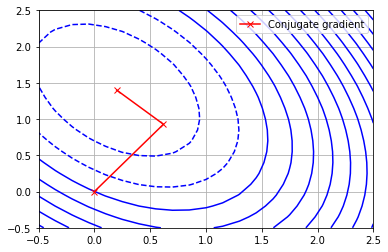

In [91]:
A = np.array([[3.,1.],[1.,2.]])
b = np.array([2.,3.])
x = np.array([0.,0.])

x, h = conjgrad(A,b,x)

y0 = [y for y, _ in h]
y1 = [y for _, y in h]
m = 21
z = np.linspace(-.5,2.5,m)
zf = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        zij = np.array([z[j],z[i]])
        zf[i,j] = (1/2)*np.dot(zij,np.dot(A,zij)) - np.dot(b,zij)

plt.plot(y0,y1,'rx-');
plt.contour(z,z,zf,15,colors='b');
plt.legend(['Conjugate gradient']);
plt.grid()